# [№1.Введение. Постановка целей и задач.](stage_1)

Часто перед владельцами ценных бумаг той или иной компании стоит задача предсказания стоимости акции через определенный промежуток времени, или в целом предсказания поведения стоимости акции на рынке в долгосрочной перспективе, для более грамотного и выгодного управлениями своими инвестициями. Однако обычными расчётами учесть все значащие факторы бывает невозможно и сами расчёты занимают много времени, поэтому для держателей акции становится выгодным и удобным решение предсказания поведения стоимости акций с помощью специальных инструментов, в числе которых `python` и его библиотеки 

Задача данной работы будет заключаться в создании на основе имеющихся данных наиболее достоверного предсказания изменения стоимости акции в ближайшем будущем, в нахождении засвисимости между несколькими параметрами датасета, фильтрации не интересующих нас данных и визуальном представлении полученного предсказания

# [№2.Импорт Датафрейма, библиотек, написание функций.](#stage_2)

## Импорт библиотек

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import lag_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse

# импорт ARIMA, SARIMA 
from statsmodels.tsa.arima_model import ARMA, ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

from statsmodels.tsa.holtwinters import ExponentialSmoothing,SimpleExpSmoothing #Модель Холта-Винтерса

from statsmodels.tsa.ar_model import AutoReg #Авторегрессия


## Загрузка датафрейма

In [87]:
df = pd.read_csv('COCO COLA.csv')

## Написание функций

Функция `writeErrors` позволяет найти для каждого метода прогнозирования их метрики

In [4]:
def writeErrors(time_series,time_series2):
  errorMAPE = mean_absolute_percentage_error(time_series, time_series2)
  errorRMSE = rmse(time_series, time_series2)
  errorMSE = mean_squared_error(time_series, time_series2)
  print(f'MAPE Error: {errorMAPE:11.10}')
  print(f'RMSE Error: {errorRMSE:11.10}')
  print(f'MSE Error: {errorMSE:11.10}')

Функция `drawPlot` прозволяет вывести графики для каждой модели прогнозирования

In [5]:
def drawPlot(time_series,time_series2):
  time_series.plot(legend=True,figsize=(12,6),title="Model:"+time_series2.name,ylabel=time_series.name,label='default').autoscale(axis='x',tight=True)
  time_series2.plot(label=time_series2.name,legend=True)

Функция `adf_test` позволяет произвести тест Дики-Фуллера

In [6]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

Функция `get_pdq` позволяет построить автокорреляцию, частичную автокорреляцию и Q-статистики

In [7]:
def get_pdq(time_series):
    plot_acf(time_series)
    plot_pacf(time_series)
    plt.show()
    print("Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics")
    r,rac,Q = sm.tsa.acf(time_series, qstat=True)
    prac = pacf(time_series,method='ywmle')
    table_data = np.c_[range(1,len(r)), r[1:],rac,prac[1:len(rac)+1],Q]
    table = pd.DataFrame(table_data, columns=['lag', "AC","Q", "PAC", "Prob(>Q)"])

    print(table)

## Убедимся в корректности загрузки данных

In [8]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200
...,...,...,...,...,...,...,...
15091,2021-12-13,56.980000,57.930000,56.959999,57.759998,57.759998,31362800
15092,2021-12-14,57.400002,58.169998,57.400002,57.799999,57.799999,24806600
15093,2021-12-15,57.930000,58.250000,57.650002,58.060001,58.060001,24923800
15094,2021-12-16,57.980000,58.880001,57.900002,58.650002,58.650002,24696900


# [№3.Знакомство с данными](stage_3)

## Ознакомимся с исходным датафреймом

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       15096 non-null  object 
 1   Open       15096 non-null  float64
 2   High       15096 non-null  float64
 3   Low        15096 non-null  float64
 4   Close      15096 non-null  float64
 5   Adj Close  15096 non-null  float64
 6   Volume     15096 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 825.7+ KB


In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,15096.000000,15096.000000,15096.000000,15096.000000,15096.000000,1.509600e+04
mean,16.056202,16.188428,15.921876,16.060734,11.367487,9.032904e+06
std,16.939301,17.064336,16.811753,16.941712,14.253637,7.935744e+06
min,0.192708,0.193359,0.182292,0.192057,0.037855,7.680000e+04
25%,0.860677,0.869792,0.854167,0.860352,0.242312,2.812800e+06
50%,9.328125,9.398438,9.218750,9.351562,4.642848,7.585200e+06
75%,28.875000,29.167500,28.563125,28.901562,17.251080,1.291275e+07
max,59.810001,60.130001,59.619999,60.130001,58.650002,1.241690e+08


In [11]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Описание столбцов таблицы

**Open -**
Цена акции на момент начала торгов

**High -**
Максимальная цена акции за период
 
**Low -**
Минимальная цена акции за период
 
**Close -**
Цена акции на закрытии торгов
 
**Adj Close -**
Скорректированная цена закрытия, отражающая стоимость этой акции после учета любых корпоративных действий
 
**Volume -**
Количество торгуемых акций или контрактов, торгуемых фьючерсами или опционами, за одну сессию торгов.

In [12]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1,1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
2,1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
3,1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
4,1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200
...,...,...,...,...,...,...,...
15091,2021-12-13,56.980000,57.930000,56.959999,57.759998,57.759998,31362800
15092,2021-12-14,57.400002,58.169998,57.400002,57.799999,57.799999,24806600
15093,2021-12-15,57.930000,58.250000,57.650002,58.060001,58.060001,24923800
15094,2021-12-16,57.980000,58.880001,57.900002,58.650002,58.650002,24696900


## Визуально изучим данные

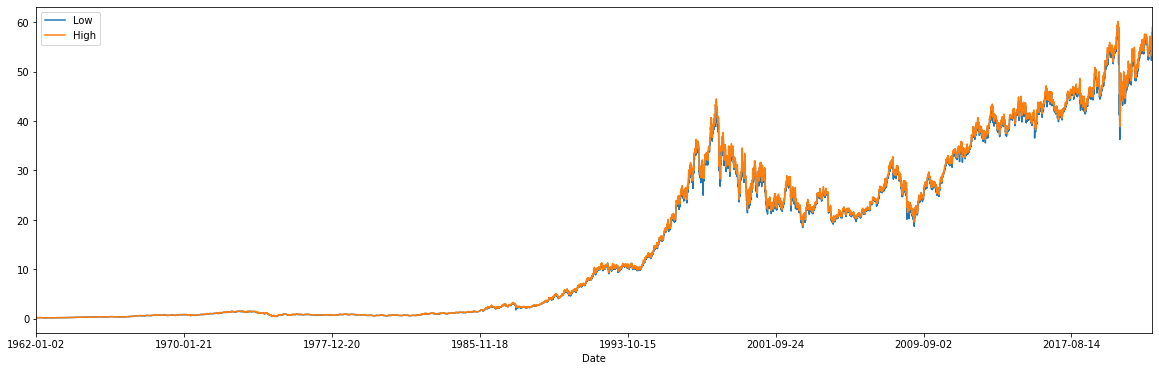

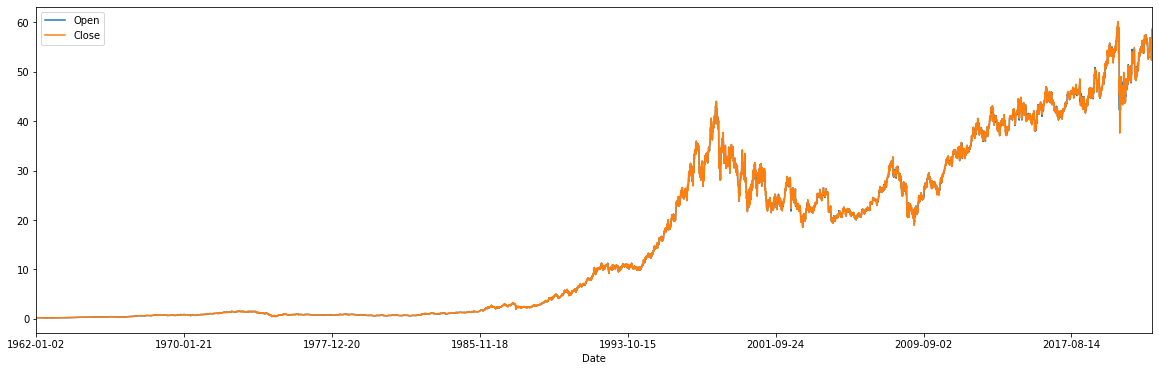

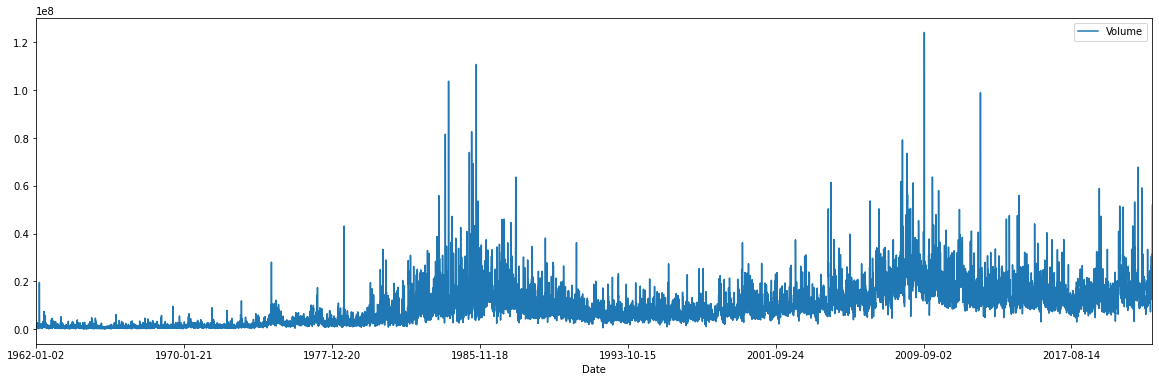

In [88]:
df.plot(y=['Low','High'], x='Date', figsize=(20,6)).autoscale(axis='x',tight=True)
df.plot(y=['Open','Close'], x='Date', figsize=(20,6)).autoscale(axis='x',tight=True)
df.plot(y=['Volume'], x='Date', figsize=(20,6)).autoscale(axis='x',tight=True)

## Создадим отдельный датафрейм для данных за последний год

### Изменим тип данных столбца `Date`, чтобы использовать его в качетсве даты

In [14]:
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15096 entries, 0 to 15095
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       15096 non-null  datetime64[ns]
 1   Open       15096 non-null  float64       
 2   High       15096 non-null  float64       
 3   Low        15096 non-null  float64       
 4   Close      15096 non-null  float64       
 5   Adj Close  15096 non-null  float64       
 6   Volume     15096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 825.7 KB


Тип данных успешно изменился

### Назначим столбец `Date` как столбец индексов

In [16]:
df = df.set_index('Date')

In [17]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.263021,0.270182,0.263021,0.263021,0.051133,806400
1962-01-03,0.259115,0.259115,0.253255,0.257161,0.049994,1574400
1962-01-04,0.257813,0.261068,0.257813,0.259115,0.050374,844800
1962-01-05,0.259115,0.262370,0.252604,0.253255,0.049234,1420800
1962-01-08,0.251302,0.251302,0.245768,0.250651,0.048728,2035200
...,...,...,...,...,...,...
2021-12-13,56.980000,57.930000,56.959999,57.759998,57.759998,31362800
2021-12-14,57.400002,58.169998,57.400002,57.799999,57.799999,24806600
2021-12-15,57.930000,58.250000,57.650002,58.060001,58.060001,24923800


### Создадим новый датафрейм по дате

In [18]:
annual_df = df[pd.to_datetime('2020-12-17'):]
annual_df.index.name = 'Date'

In [19]:
annual_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2020-12-17 to 2021-12-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [20]:
annual_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,53.922016,54.261976,53.576680,53.911937,52.953782,1.581336e+07
std,2.412296,2.368503,2.432905,2.420885,2.719960,7.705447e+06
min,48.270000,48.689999,48.110001,48.150002,46.678406,3.265500e+06
25%,52.779999,53.200001,52.430000,52.759998,51.641926,1.149890e+07
50%,54.310001,54.590000,54.009998,54.320000,53.465385,1.394150e+07
75%,55.830002,56.130001,55.520000,55.860001,55.014942,1.759860e+07
max,58.490002,58.919998,57.900002,58.650002,58.650002,6.784570e+07


## Визуально изучим новый датафрейм

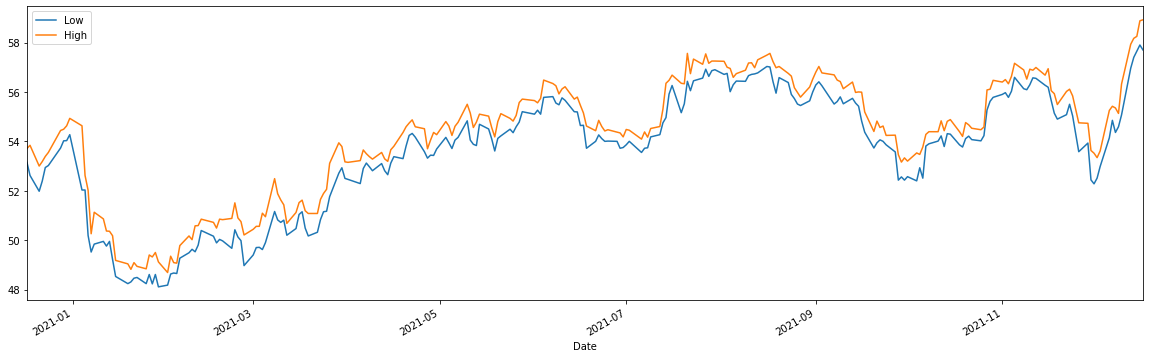

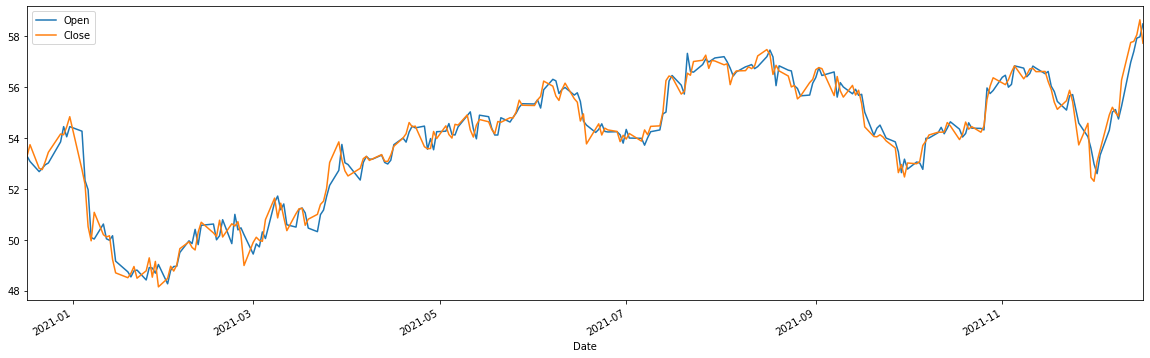

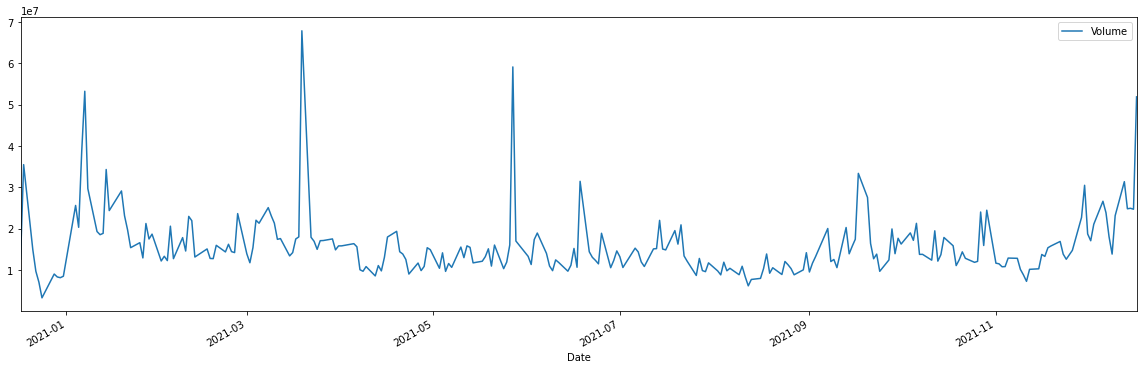

In [91]:
annual_df.plot(y=['Low','High'], figsize=(20,6)).autoscale(axis='x',tight=True)
annual_df.plot(y=['Open','Close'], figsize=(20,6)).autoscale(axis='x',tight=True)
annual_df.plot(y=['Volume'], figsize=(20,6)).autoscale(axis='x',tight=True)

## Выводы

Было произведено общее ознакомление с датасетом. Рассмотрена корректность загрузки индексов и столбцов. Рассмотрены представленные в датасете данные и посчитаны основные статистики. Выведены графики по схожим между собой параметрам в датасете. Был создан новый датасет, включающий в себя только данные за последний год, и визуализированны его данные.

# [№4.Предобработка данных](stage_4)

## Фильтрация данных

### Создадим в датафрейме новый стобец `Difference` отражающий разницу между ценой акции на открытии и закрытии торгов

In [22]:
df['Difference'] = df['Close'] - df['Open']

### Создадим новый датафрейм, включающий в себя только нужные стобцы

In [23]:
main_df = df[['Open','Close','High','Low','Volume','Difference']][pd.to_datetime('2020-12-17'):]

### Ознакомимся с полученным датафреймом

In [24]:
main_df

,Open,Close,High,Low,Volume,Difference
Date,,,,,,
2020-12-17,53.299999,53.270000,53.709999,53.150002,12677300,-0.029999
2020-12-18,53.080002,53.740002,53.840000,52.619999,35480100,0.660000
2020-12-21,52.680000,52.810001,53.000000,51.980000,14926600,0.130001
2020-12-22,52.810001,52.759998,53.180000,52.389999,9689500,-0.050003
2020-12-23,52.950001,53.080002,53.389999,52.939999,7040300,0.130001
...,...,...,...,...,...,...
2021-12-13,56.980000,57.759998,57.930000,56.959999,31362800,0.779998
2021-12-14,57.400002,57.799999,58.169998,57.400002,24806600,0.399997
2021-12-15,57.930000,58.060001,58.250000,57.650002,24923800,0.130001


In [25]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2020-12-17 to 2021-12-17
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        253 non-null    float64
 1   Close       253 non-null    float64
 2   High        253 non-null    float64
 3   Low         253 non-null    float64
 4   Volume      253 non-null    int64  
 5   Difference  253 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


In [26]:
main_df.describe()

,Open,Close,High,Low,Volume,Difference
count,253.000000,253.000000,253.000000,253.000000,2.530000e+02,253.000000
mean,53.922016,53.911937,54.261976,53.576680,1.581336e+07,-0.010079
std,2.412296,2.420885,2.368503,2.432905,7.705447e+06,0.433619
min,48.270000,48.150002,48.689999,48.110001,3.265500e+06,-1.510002
25%,52.779999,52.759998,53.200001,52.430000,1.149890e+07,-0.270000
50%,54.310001,54.320000,54.590000,54.009998,1.394150e+07,0.019996
75%,55.830002,55.860001,56.130001,55.520000,1.759860e+07,0.259998
max,58.490002,58.650002,58.919998,57.900002,6.784570e+07,1.239998


## Обработка пропусков

### Проверим датасет на наличие пропусков в данных

In [27]:
print(main_df.isnull().sum())

Open          0
Close         0
High          0
Low           0
Volume        0
Difference    0
dtype: int64


In [28]:
print(pd.isna(main_df.index).sum())

0


#### *Несмотря на то, что в датафрейме нет пустых строк, в нём пропущены некоторые данные. Наша задача восстановсить их*

### Вставим пропущенные строки дат в датафрейм

In [29]:
main_df = (main_df
         .set_index(main_df.index)
         .reindex(pd.date_range(main_df.index.min(), main_df.index.max()))
         .reset_index())

### Выполним интерполяцию для остальных столбцов

In [30]:
main_df[['Open', 'Close', 'High', 'Low', 'Volume', 'Difference']] = main_df[['Open', 'Close', 'High', 'Low', 'Volume', 'Difference']].interpolate()

### Убедимся в отсутствии пустых строк

In [31]:
main_df

,index,Open,Close,High,Low,Volume,Difference
0,2020-12-17,53.299999,53.270000,53.709999,53.150002,1.267730e+07,-0.029999
1,2020-12-18,53.080002,53.740002,53.840000,52.619999,3.548010e+07,0.660000
2,2020-12-19,52.946668,53.430002,53.560000,52.406666,2.862893e+07,0.483334
3,2020-12-20,52.813334,53.120001,53.280000,52.193333,2.177777e+07,0.306667
4,2020-12-21,52.680000,52.810001,53.000000,51.980000,1.492660e+07,0.130001
...,...,...,...,...,...,...,...
361,2021-12-13,56.980000,57.759998,57.930000,56.959999,3.136280e+07,0.779998
362,2021-12-14,57.400002,57.799999,58.169998,57.400002,2.480660e+07,0.399997
363,2021-12-15,57.930000,58.060001,58.250000,57.650002,2.492380e+07,0.130001
364,2021-12-16,57.980000,58.650002,58.880001,57.900002,2.469690e+07,0.670002


In [32]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       366 non-null    datetime64[ns]
 1   Open        366 non-null    float64       
 2   Close       366 non-null    float64       
 3   High        366 non-null    float64       
 4   Low         366 non-null    float64       
 5   Volume      366 non-null    float64       
 6   Difference  366 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 20.1 KB


### Переименуем `index` обратно в `Date` для удобства

In [33]:
main_df.rename(columns={'index':'Date'}, inplace=True)

# [№5.Разведочный анализ данных](stage_5)

### Сделаем столбец с датами индексом датасета

In [34]:
main_df = main_df.set_index('Date')

### Выведем статистику для нового датасета

In [35]:
main_df

,Open,Close,High,Low,Volume,Difference
Date,,,,,,
2020-12-17,53.299999,53.270000,53.709999,53.150002,1.267730e+07,-0.029999
2020-12-18,53.080002,53.740002,53.840000,52.619999,3.548010e+07,0.660000
2020-12-19,52.946668,53.430002,53.560000,52.406666,2.862893e+07,0.483334
2020-12-20,52.813334,53.120001,53.280000,52.193333,2.177777e+07,0.306667
2020-12-21,52.680000,52.810001,53.000000,51.980000,1.492660e+07,0.130001
...,...,...,...,...,...,...
2021-12-13,56.980000,57.759998,57.930000,56.959999,3.136280e+07,0.779998
2021-12-14,57.400002,57.799999,58.169998,57.400002,2.480660e+07,0.399997
2021-12-15,57.930000,58.060001,58.250000,57.650002,2.492380e+07,0.130001


In [36]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-12-17 to 2021-12-17
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        366 non-null    float64
 1   Close       366 non-null    float64
 2   High        366 non-null    float64
 3   Low         366 non-null    float64
 4   Volume      366 non-null    float64
 5   Difference  366 non-null    float64
dtypes: float64(6)
memory usage: 20.0 KB


In [37]:
main_df.describe()

,Open,Close,High,Low,Volume,Difference
count,366.000000,366.000000,366.000000,366.000000,3.660000e+02,366.000000
mean,53.893757,53.889290,54.237541,53.544836,1.590390e+07,-0.004467
std,2.404255,2.411571,2.361117,2.427659,7.356444e+06,0.404201
min,48.270000,48.150002,48.689999,48.110001,3.265500e+06,-1.510002
25%,52.786874,52.810001,53.235000,52.401668,1.166105e+07,-0.229166
50%,54.312501,54.259998,54.568332,54.000000,1.428837e+07,0.009999
75%,55.817500,55.852501,56.117500,55.518333,1.757748e+07,0.220001
max,58.490002,58.650002,58.919998,57.900002,6.784570e+07,1.239998


### Построим графическое отображение столбцов

Index(['Open', 'Close', 'High', 'Low', 'Volume', 'Difference'], dtype='object')


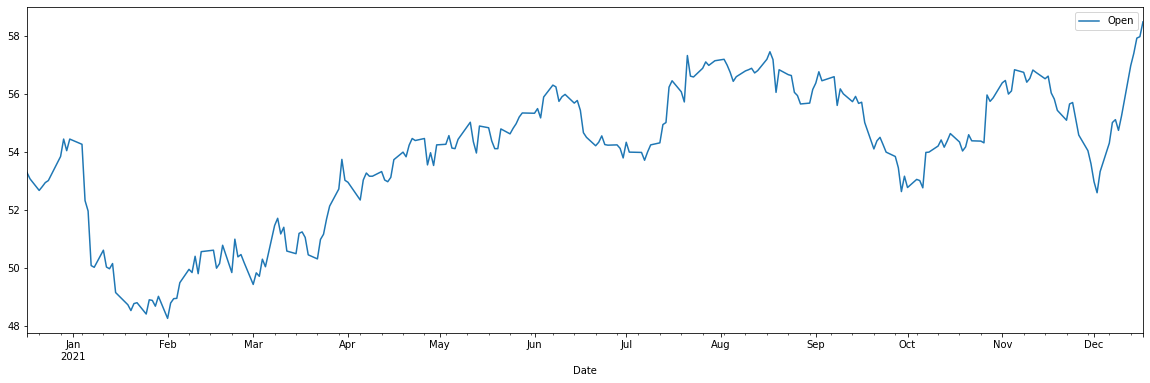

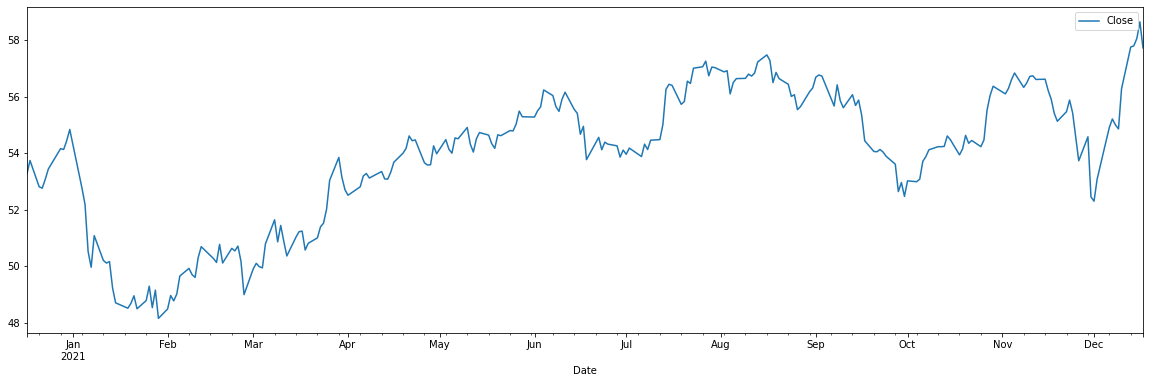

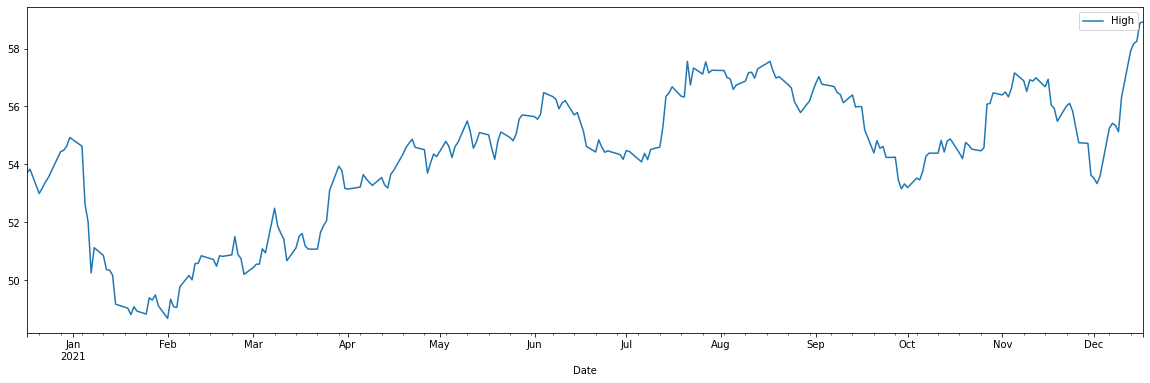

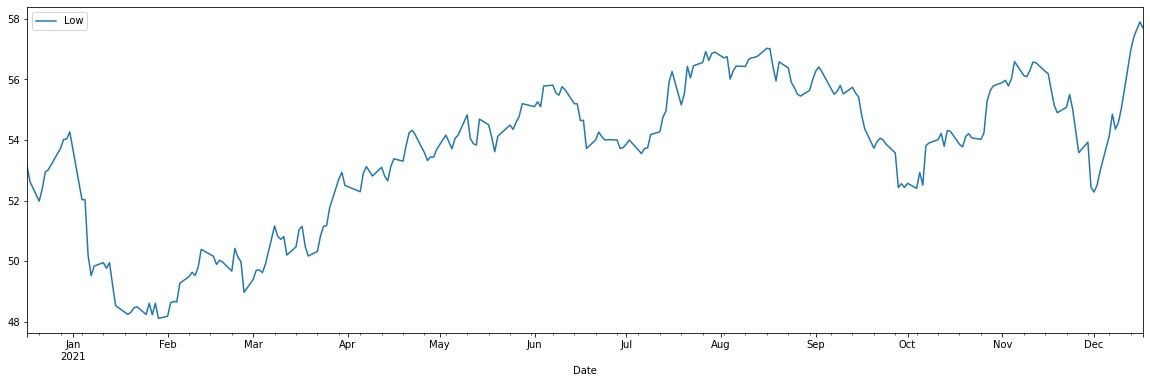

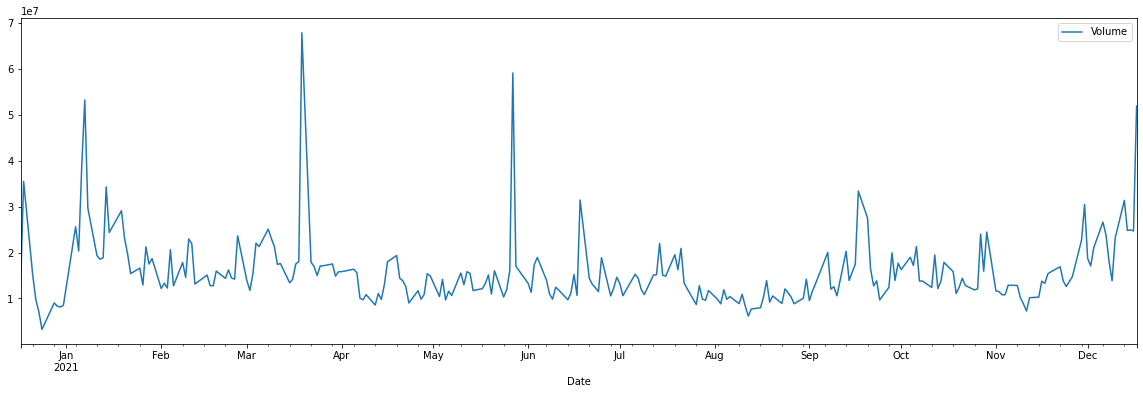

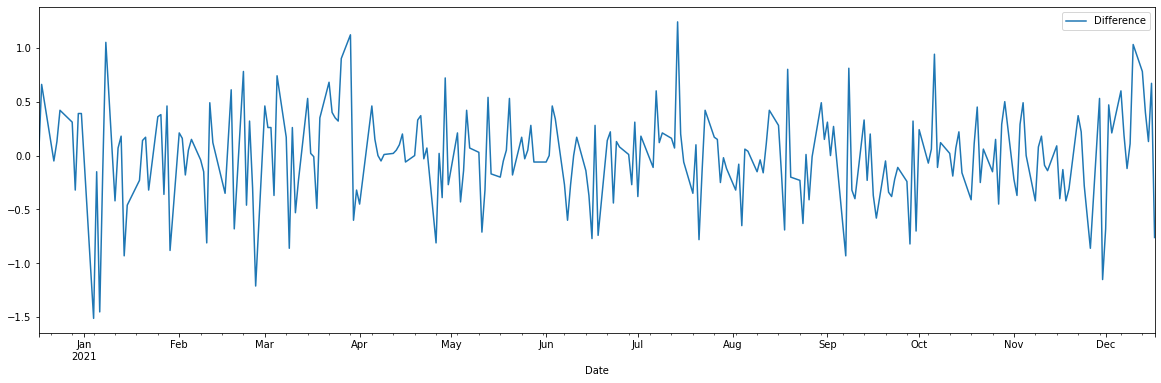

In [38]:
print(main_df.columns)
for i in main_df.columns[0:]:
   main_df[i].plot(figsize=(20,6),legend=True).autoscale(axis='x',tight=True);
   plt.show()

In [39]:
main_df1 = main_df.copy()

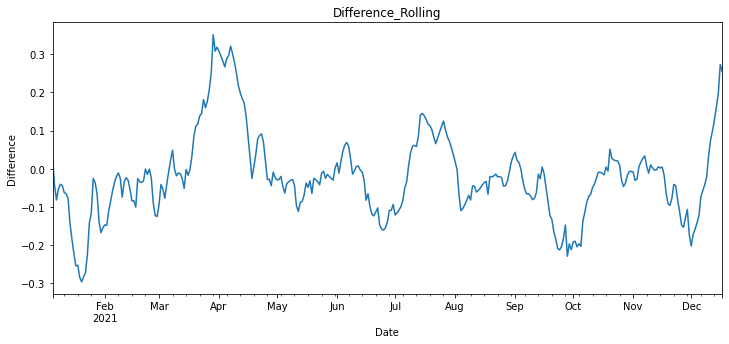

In [40]:
main_df1['Rolling'] = main_df['Difference'].rolling(window=20).mean()
main_df1['Rolling'].plot(figsize=(12,5), ylabel='Difference', title='Difference_Rolling').autoscale(axis='x',tight=True);

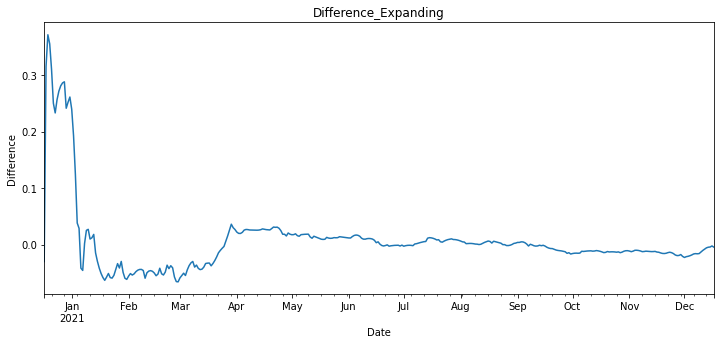

In [41]:
main_df1['Expanding']=main_df['Difference'].expanding().mean()
main_df1['Expanding'].plot(figsize=(12,5),ylabel='Difference', title='Difference_Expanding');

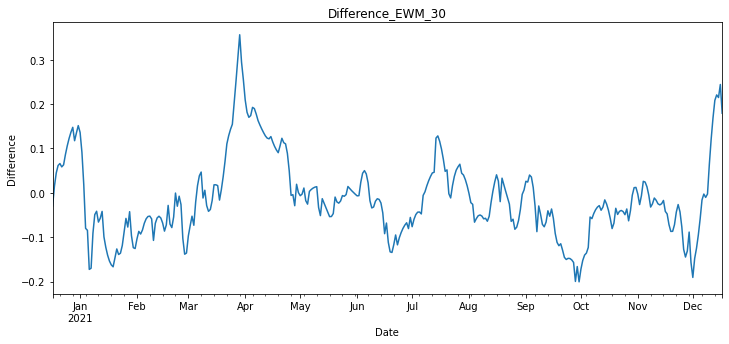

In [83]:
main_df1['EWM_12']=main_df['Difference'].ewm(span=30, adjust=False).mean()
main_df1['EWM_12'].plot(figsize=(12,5),ylabel='Difference', title='Difference_EWM_30').autoscale(axis='x',tight=True);

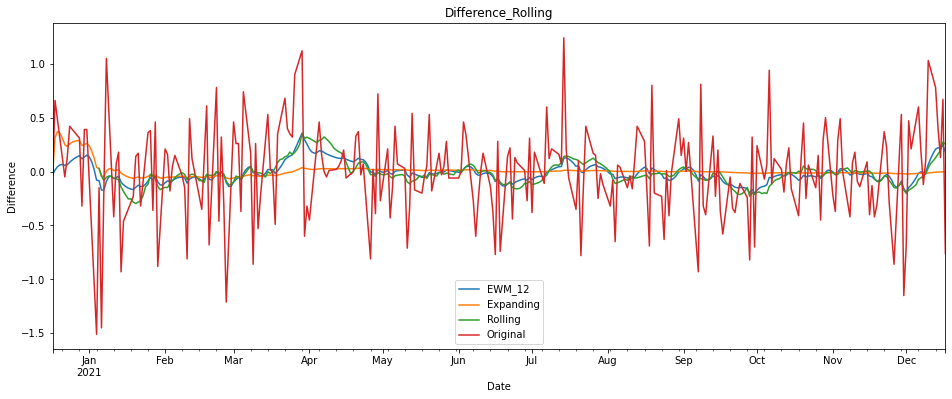

In [92]:
#На одном графике
main_df1['EWM_12'].plot(figsize=(16,6),legend=True,ylabel='Difference', title='Difference_Rolling').autoscale(axis='x',tight=True);
main_df1['Expanding'].plot(figsize=(16,6),legend=True).autoscale(axis='x',tight=True);
main_df1['Rolling'].plot(figsize=(16,6),legend=True).autoscale(axis='x',tight=True);
main_df1['Difference'].plot(figsize=(16,6),legend=True,label="Original").autoscale(axis='x',tight=True);

## Выводы

Было построено графическое представление данных в столбцах основного датафрейма, а также была произведена и выведена на экран апроксимация с использованием трёх функций: `ewm()`, `expanding()` и `rolling()`

# [№6.Построение моделей и анализ результатов](stage_6)

## Разобьём датасет на сезонность и тренд

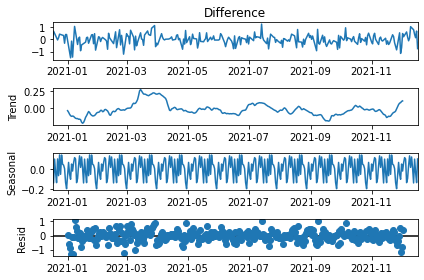

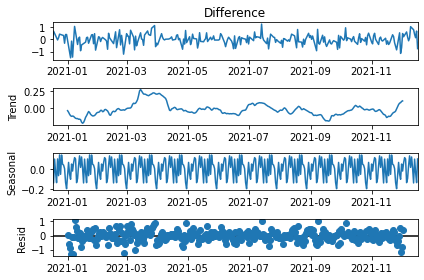

In [44]:
result = seasonal_decompose(main_df1['Difference'], model='add', period = 30)
result.plot()

### Рассмотрим сезонность поближе

<AxesSubplot:title={'center':'Seasonal'}, xlabel='Date'>

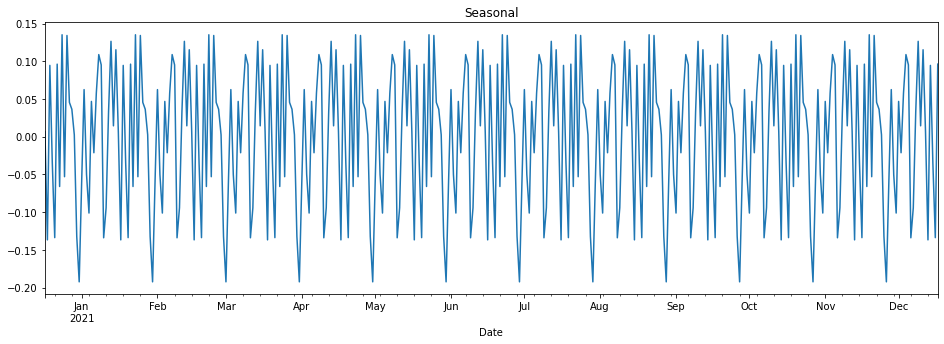

In [45]:
result.seasonal.plot(title='Seasonal', figsize=(16,5))

### Рассмотрим тренд поближе

<AxesSubplot:title={'center':'Trend'}, xlabel='Date'>

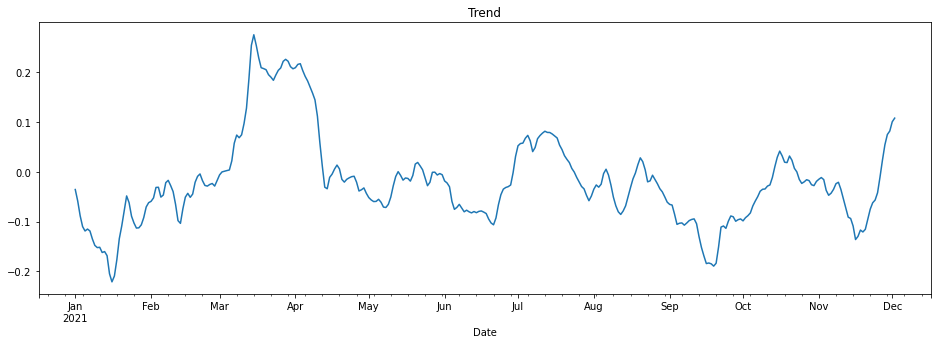

In [46]:
result.trend.plot(title='Trend', figsize=(16,5))

## Найдём корреляцию между `Volume` и `Difference` 

In [47]:
main_df1['Difference'].corr(main_df1['Volume'])

-0.03595820815951735

## Построим диаграмму корреляции

<AxesSubplot:>

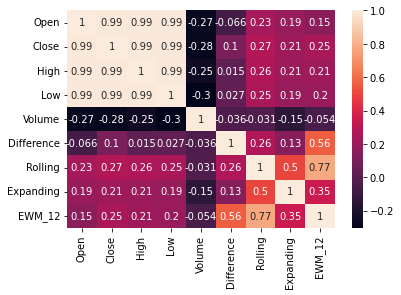

In [48]:
correlation = main_df1.loc[:,main_df1.columns].corr()
sn.heatmap(correlation, annot=True)

### Выведем на экран автокорреляцию, частичную корреляцию и Q-статистики

-------------------------------------------------------------------------------------------------
Open
-------------------------------------------------------------------------------------------------


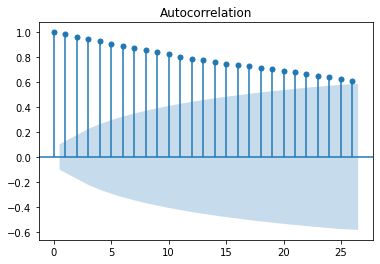

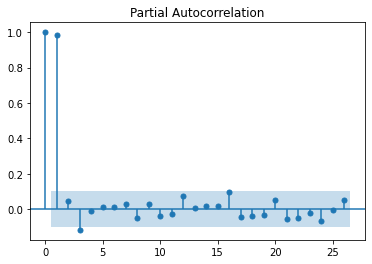

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.982025   355.861839  0.982025   2.242182e-79
1    2.0  0.965754   700.974173  0.038740  6.100879e-153
2    3.0  0.946184  1033.154193 -0.098773  1.155739e-223
3    4.0  0.927094  1352.946370 -0.004811  1.102353e-291
4    5.0  0.908348  1660.787252  0.008930   0.000000e+00
5    6.0  0.890298  1957.336860  0.009507   0.000000e+00
6    7.0  0.873505  2243.599820  0.025289   0.000000e+00
7    8.0  0.855661  2519.053924 -0.039018   0.000000e+00
8    9.0  0.839395  2784.877684  0.026796   0.000000e+00
9   10.0  0.821896  3040.449210 -0.034032   0.000000e+00
10  11.0  0.804399  3285.944587 -0.018561   0.000000e+00
11  12.0  0.789061  3522.834618  0.058197   0.000000e+00
12  13.0  0.773934  3751.374299  0.003941   0.000000e+00
13  14.0  0.760184  3972.491924  0.018790   0.000000e+00
14  15.0  0.747088  4186.665220  0.014870   0.000000e+00
15  16.0 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


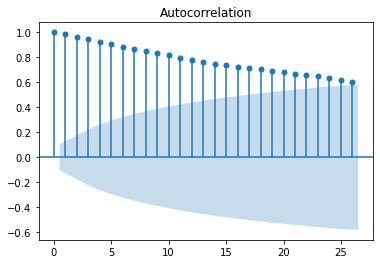

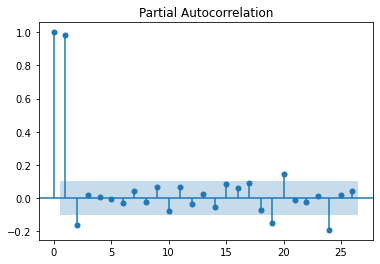

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.983565   356.978855  0.983565   1.280670e-79
1    2.0  0.963063   700.170996 -0.133051  9.115910e-153
2    3.0  0.942822  1029.994574  0.013110  5.601427e-223
3    4.0  0.923231  1347.127640  0.005952  2.013598e-290
4    5.0  0.903996  1652.025465 -0.003487   0.000000e+00
5    6.0  0.884403  1944.660888 -0.022898   0.000000e+00
6    7.0  0.866146  2226.120731  0.034898   0.000000e+00
7    8.0  0.847951  2496.633457 -0.018731   0.000000e+00
8    9.0  0.831639  2757.566995  0.050712   0.000000e+00
9   10.0  0.814109  3008.318952 -0.061077   0.000000e+00
10  11.0  0.797925  3249.878631  0.046942   0.000000e+00
11  12.0  0.781658  3482.344495 -0.025537   0.000000e+00
12  13.0  0.766015  3706.231179  0.016681   0.000000e+00
13  14.0  0.749727  3921.307491 -0.037845   0.000000e+00
14  15.0  0.735169  4128.701310  0.060744   0.000000e+00
15  16.0 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


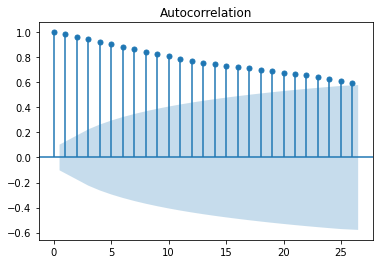

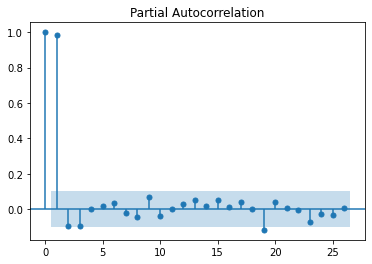

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.983666   357.051648  0.983666   1.234771e-79
1    2.0  0.965056   701.665435 -0.078452  4.318041e-153
2    3.0  0.944066  1032.359888 -0.078565  1.718599e-223
3    4.0  0.923060  1349.375217 -0.001885  6.556026e-291
4    5.0  0.902625  1653.349188  0.011346   0.000000e+00
5    6.0  0.883469  1945.367090  0.026078   0.000000e+00
6    7.0  0.864400  2225.693351 -0.015195   0.000000e+00
7    8.0  0.844623  2494.086931 -0.037574   0.000000e+00
8    9.0  0.826815  2752.002257  0.054695   0.000000e+00
9   10.0  0.808339  2999.212303 -0.033838   0.000000e+00
10  11.0  0.790354  3236.209669  0.000280   0.000000e+00
11  12.0  0.773363  3463.767834  0.021893   0.000000e+00
12  13.0  0.758143  3683.076824  0.040200   0.000000e+00
13  14.0  0.743937  3894.844147  0.015892   0.000000e+00
14  15.0  0.731700  4100.285779  0.041459   0.000000e+00
15  16.0 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


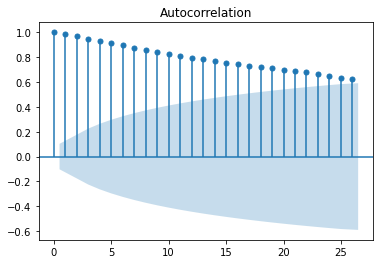

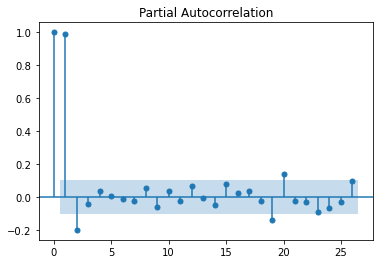

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC            Q       PAC       Prob(>Q)
0    1.0  0.986216   358.905186  0.986216   4.875032e-80
1    2.0  0.968288   705.831287 -0.158250  5.378777e-154
2    3.0  0.948986  1039.981868 -0.037669  3.816600e-225
3    4.0  0.930376  1362.041959  0.027675  1.175288e-293
4    5.0  0.912504  1672.706523  0.010369   0.000000e+00
5    6.0  0.894929  1972.349262 -0.007892   0.000000e+00
6    7.0  0.877227  2261.057242 -0.016903   0.000000e+00
7    8.0  0.860766  2539.807698  0.039911   0.000000e+00
8    9.0  0.843712  2808.372378 -0.043497   0.000000e+00
9   10.0  0.827472  3067.423232  0.025300   0.000000e+00
10  11.0  0.811132  3317.045838 -0.017223   0.000000e+00
11  12.0  0.796403  3558.364866  0.051224   0.000000e+00
12  13.0  0.782303  3791.874305 -0.000912   0.000000e+00
13  14.0  0.767767  4017.425206 -0.034281   0.000000e+00
14  15.0  0.754671  4235.968363  0.057645   0.000000e+00
15  16.0 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


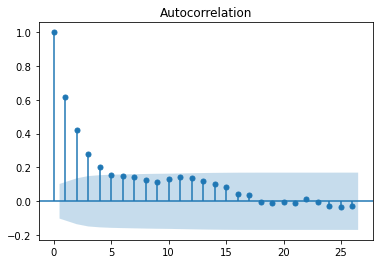

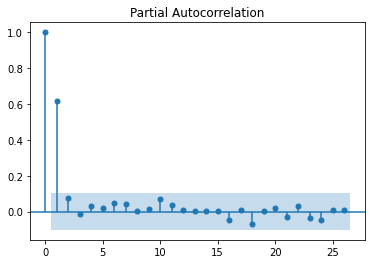

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC           Q       PAC      Prob(>Q)
0    1.0  0.614270  139.236871  0.614270  3.909269e-32
1    2.0  0.424297  205.851136  0.075432  1.995234e-45
2    3.0  0.277893  234.504661 -0.015207  1.468304e-50
3    4.0  0.204929  250.129929  0.033048  6.103382e-53
4    5.0  0.156811  259.304250  0.018806  5.537906e-54
5    6.0  0.146561  267.340706  0.047565  8.039727e-55
6    7.0  0.144673  275.193243  0.040270  1.189582e-55
7    8.0  0.126834  281.245457  0.003865  4.014560e-56
8    9.0  0.114525  286.193858  0.016244  2.205631e-56
9   10.0  0.134518  293.039901  0.065675  4.597340e-57
10  11.0  0.144751  300.989483  0.037499  5.420596e-58
11  12.0  0.136704  308.099796  0.008528  9.339820e-59
12  13.0  0.119600  313.557573  0.002438  3.484217e-59
13  14.0  0.101590  317.506603  0.002726  2.617841e-59
14  15.0  0.086003  320.344818  0.005127  3.262630e-59
15  16.0  0.045791  321.151727 -0.042536 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


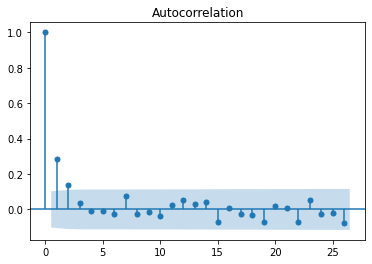

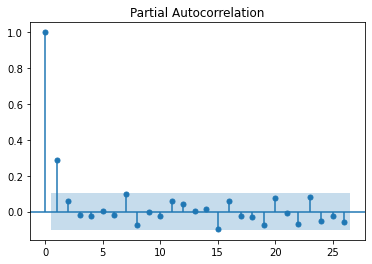

Estimated autocorrelation (AC), partial autocorrelation (PAC) and Q-statistics
     lag        AC          Q       PAC      Prob(>Q)
0    1.0  0.285796  30.140313  0.285796  4.018895e-08
1    2.0  0.136771  37.062066  0.059992  8.955184e-09
2    3.0  0.035183  37.521347 -0.020444  3.569161e-08
3    4.0 -0.008755  37.549863 -0.023357  1.387605e-07
4    5.0 -0.007317  37.569841  0.001414  4.603492e-07
5    6.0 -0.023480  37.776111 -0.019230  1.242433e-06
6    7.0  0.074991  39.885991  0.095275  1.323638e-06
7    8.0 -0.026133  40.142920 -0.073220  3.013180e-06
8    9.0 -0.011910  40.196439 -0.003565  7.000408e-06
9   10.0 -0.035746  40.679874 -0.026535  1.285568e-05
10  11.0  0.026761  40.951579  0.054654  2.456720e-05
11  12.0  0.051958  41.978729  0.039066  3.358088e-05
12  13.0  0.030252  42.327916  0.003501  5.788010e-05
13  14.0  0.043703  43.058743  0.013076  8.383714e-05
14  15.0 -0.073538  45.133863 -0.093638  7.293552e-05
15  16.0  0.010196  45.173867  0.054984  1.305233e-04
16 

E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


In [49]:
for i in main_df.columns[0:]:
  print('-------------------------------------------------------------------------------------------------')
  print(i)
  print('-------------------------------------------------------------------------------------------------')
  get_pdq(main_df[i])
  print('')

## Избавимся от тренда путём дифференцирования

Open


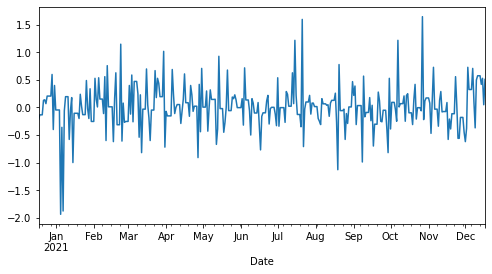

Close


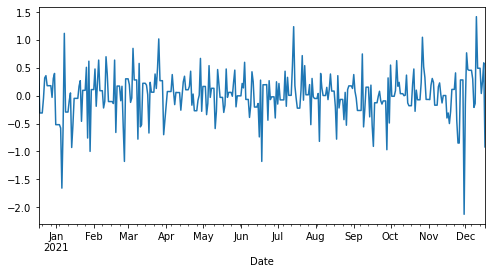

High


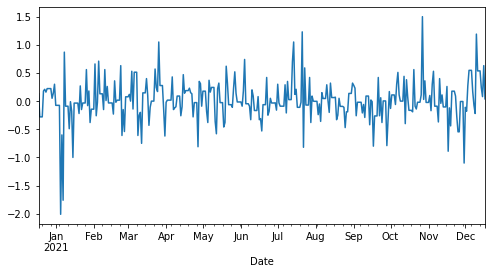

Low


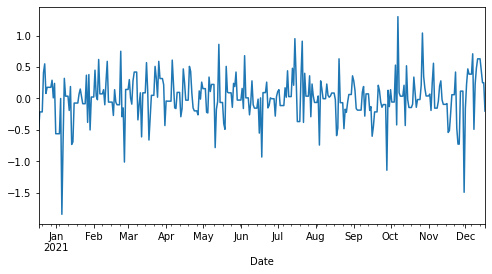

Volume


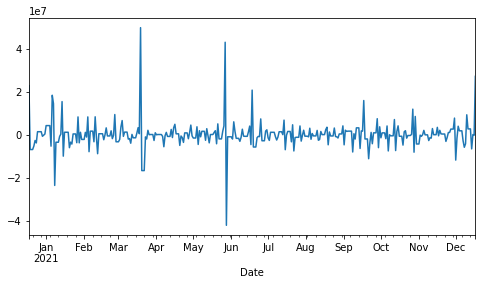

In [50]:
df_stat=main_df1.copy()
for i in df_stat.columns[0:5]:
  print(i)
  df_stat[i] = df_stat[i]-df_stat[i].shift(1)
  df_stat[i].dropna().plot(figsize=(8, 4))
  plt.show()

## С помощью теста Дики-Фуллера проверим данные на статичность

Тест ADF используется для определения наличия единичного корня в ряду и, следовательно, помогает понять, является ли ряд стационарным или нет. Нулевая и альтернативная гипотезы этого теста:

Нулевая гипотеза: серия имеет единичный корень.

Альтернативная гипотеза: у ряда нет единичного корня.

Если нулевую гипотезу отклонить не удалось, этот тест может предоставить свидетельство того, что ряд нестационарен.
Создадим функцию для выполнения теста ADF проверки временного ряда.

In [51]:
for i in main_df1.columns[0:6]:
  print('--------------------------------')
  print(i)
  adf_test(main_df1[i])

--------------------------------
Open
Results of Dickey-Fuller Test:
Test Statistic                  -1.180315
p-value                          0.682006
#Lags Used                       2.000000
Number of Observations Used    363.000000
Critical Value (1%)             -3.448494
Critical Value (5%)             -2.869535
Critical Value (10%)            -2.571029
dtype: float64
--------------------------------
Close
Results of Dickey-Fuller Test:
Test Statistic                  -1.342446
p-value                          0.609537
#Lags Used                       1.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64
--------------------------------
High
Results of Dickey-Fuller Test:
Test Statistic                  -1.314700
p-value                          0.622420
#Lags Used                       2.000000
Number of Observations Used    363.000000
Critic

Основываясь на уровне значимости 0,05 и p-value теста ADF, нулевая гипотеза не может быть отклонена. Следовательно, ряды нестационарены.

# Разделение датасета на тренировочную и тестовую выборки

In [52]:
train = main_df1.iloc[:len(main_df1)-30]
test = main_df1.iloc[len(main_df1)-30:]
start=len(train)
end=len(train)+len(test)-1

# Первый способ прогнозирования: SARIMA

### Краткое описание модели

Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

Он добавляет три гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.

### Создание модели


In [109]:
auto_arima(main_df1['Difference'], seasonal=True, m=30).summary()
model1 = SARIMAX(train['Difference'], order=(1,1,2), seasonal_order=(1,2,1,30))
result1 = model1.fit()
result1.summary()

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Difference   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(1, 2, [1], 30)   Log Likelihood                -244.952
Date:                              Fri, 25 Mar 2022   AIC                            501.905
Time:                                      20:23:41   BIC                            523.605
Sample:                                  12-17-2020   HQIC                           510.614
                                       - 11-17-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4896      0.161      3.034      0.002       0.173       0.806
ma.L1         -1.2314      0.238     -5.174      0.000      -1.698      -0.765
ma.L2          0.2344      0.192      1.222      0.222      -0.142       0.610
ar.S.L30      -0.4542      0.054     -8.424      0.000      -0.560      -0.349
ma.S.L30      -0.9999    405.972     -0.002      0.998    -796.690     794.690
sigma2         0.2383     96.744      0.002      0.998    -189.376     189.852
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 5.89
Prob(Q):                              0.85   Prob(JB):                         0.05
Heteroskedasticity (H):               0.49   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Создание прогноза

In [110]:
prediction1 = result1.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1, 1, 2)x(1, 2, [1], 7)	')

### Сравнение прогноза и предсказания

<AxesSubplot:title={'center':'Difference'}, xlabel='Date', ylabel='Difference'>

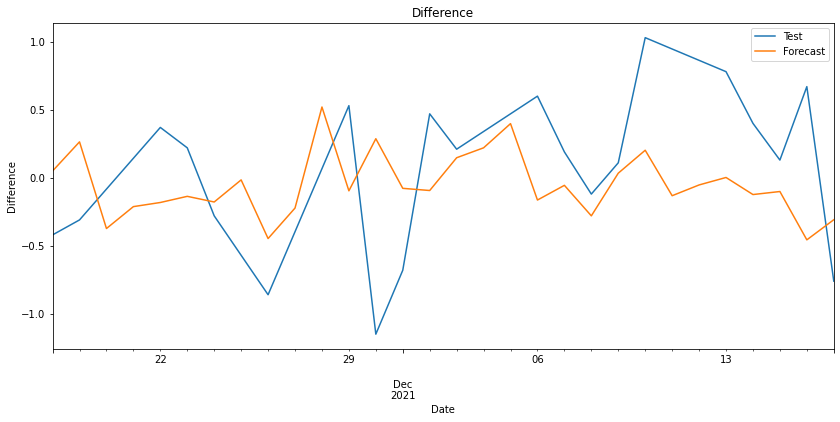

In [111]:
#График тестовых значений и предсказания
test['Difference'].plot(legend=True, label='Test')
prediction1.plot(legend=True, figsize=(14,6), ylabel='Difference', title='Difference', label='Forecast')

In [112]:
#Предсказание на всем датасете
forecast1 = result1.predict(len(main_df1)-1,len(main_df1)+30,typ='levels').rename('SARIMAX(1, 1, 2)x(1, 2, [1], 30)')

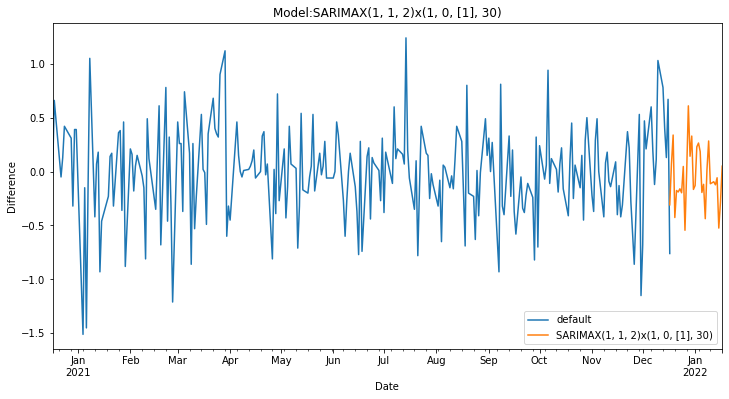

In [113]:
drawPlot(main_df1['Difference'], forecast1)

### Рассчитываем качество полученной модели и прогноза

In [114]:
writeErrors(test['Difference'], prediction1)

MAPE Error: 1.345957773
RMSE Error: 0.6012762974
MSE Error: 0.3615331858


### Делаем выводы по прогнозу

--------------

# Второй способ прогнозирования: Модель Холта-Винтерса


### Краткое описание метода

Модель Хольта-Винтерса является одним из методов прогнозирования с использованием так называемых экспоненциальное сглаживание. Сглаживание состоит в создании взвешенного скользящего среднего, вес которого определяется по схеме - чем старше информация об изучаемом явлении, тем меньше значение для текущего прогноза.

### Создание модели

In [61]:
model2 = ExponentialSmoothing(train['Difference'], seasonal='add', seasonal_periods=30, freq ='D').fit()

E:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


### Создание прогноза


In [62]:
prediction2 = model2.predict(start=start, end=end)

### Сравнение прогноза и предсказания

<AxesSubplot:title={'center':'Difference'}, xlabel='Date', ylabel='Difference'>

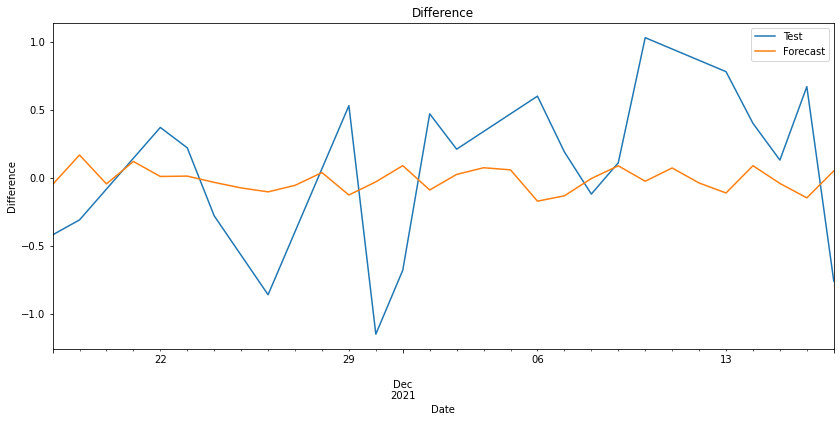

In [63]:
test['Difference'].plot(legend=True,label='Test')
prediction2.plot(legend=True, figsize=(14,6), ylabel='Difference', title='Difference', label='Forecast')

In [64]:
result2 = ExponentialSmoothing(main_df1['Difference'], seasonal='add', seasonal_periods=30, freq ='D').fit()
forecast2 = result2.predict(start=len(main_df1['Difference'])-1, end=len(main_df1['Difference'])+30).rename("Holt-Winters")

E:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


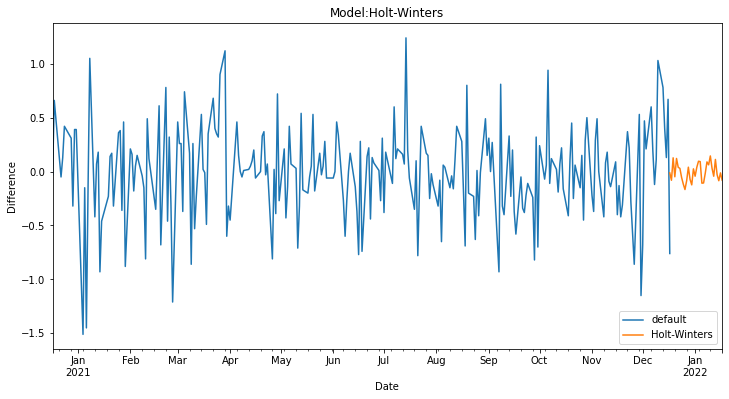

In [65]:
drawPlot(main_df1['Difference'], forecast2)

### Рассчитываем качество полученной модели и прогноза

In [66]:
writeErrors(test['Difference'],  prediction2)

MAPE Error: 0.9538173863
RMSE Error: 0.5788895886
MSE Error: 0.3351131558


### Делаем выводы по прогнозу

-------------

# Третий способ прогнозирования: Авторегрессионная модель (AR)

### Краткое описание метода

Авторегрессионная (AR) модель (англ. autoregressive model) - Модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда.

### Создание модели

In [67]:
model3 = AutoReg(main_df1['Difference'], lags=15, period=30).fit()

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
E:\Anaconda\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


### Создание прогноза

In [68]:
prediction3 = model3.predict(start=start, end=end).rename('AR')

### Сравнение прогноза и предсказания

<AxesSubplot:title={'center':'Difference'}, xlabel='Date', ylabel='Difference'>

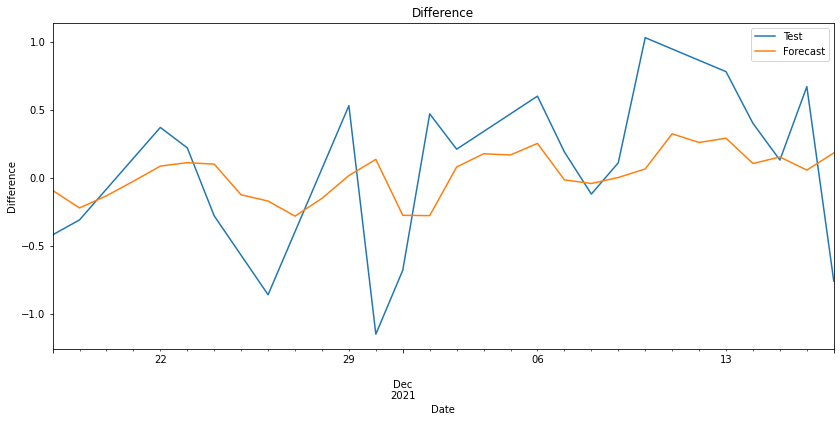

In [69]:
test['Difference'].plot(label='Test',legend=True)
prediction3.plot(legend=True, figsize=(14,6), ylabel='Difference', title='Difference', label='Forecast')

In [78]:
prediction3 = model3.predict(start=len(main_df1['Difference']-1), end=len(main_df1['Difference'])+29, dynamic = True).rename('AR')

E:\Anaconda\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


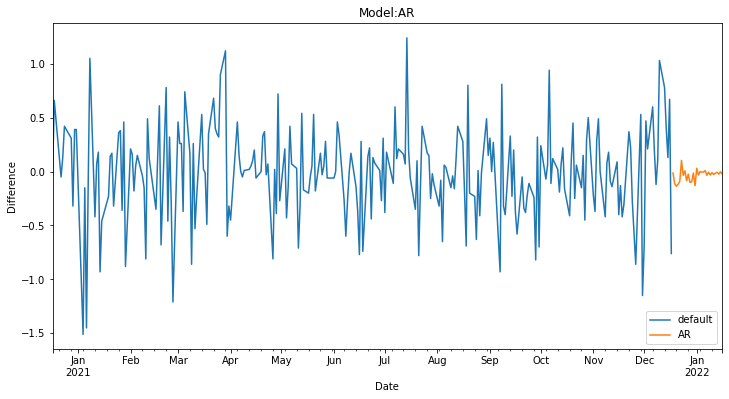

In [79]:
drawPlot(main_df1['Difference'], prediction3)

In [80]:
forecast3 = model3.predict(start=start, end=end, dynamic = True)

### Рассчитываем качество полученной модели и прогноза

In [81]:
writeErrors(test['Difference'], prediction3)

MAPE Error:  1.03735184
RMSE Error: 0.5572174783
MSE Error: 0.3104913182


### Делаем выводы по прогнозу

фф

----------------------------------------------------------------------

## Сравним метрики каждого метода прогнозирования

In [82]:
print('Модель SARIMA')
writeErrors(test['Difference'], prediction1)
print('-----------------------------')
print('Модель Холта-Винтерса')
writeErrors(test['Difference'], prediction2)
print('-----------------------------')
print('Авторегрессионная модель (AR)')
writeErrors(test['Difference'], prediction3)

Модель SARIMA
MAPE Error: 1.050377331
RMSE Error: 0.5577197156
MSE Error: 0.3110512811
-----------------------------
Модель Холта-Винтерса
MAPE Error: 0.9538173863
RMSE Error: 0.5788895886
MSE Error: 0.3351131558
-----------------------------
Авторегрессионная модель (AR)
MAPE Error:  1.03735184
RMSE Error: 0.5572174783
MSE Error: 0.3104913182


## Выводы

Было произведенно моделирование, обучение и проверка с тестовыми значениями. Посчитаны метрики для каждой модели, лучший результат показала *Авторегрессионная модель(AR)*. Также был расчитан прогноз дальнейшего изменения параметра `Difference` со временем
Была проведена апроксимация. Построенны автокорреляционная и частично корреляционные функции. Расчитана корреляция, свидетельствующая об отсутствии прямой взаимосвязи между параметром `Difference` и `Volume`. Был использован тест для проверки стационарности временного ряда - тест ADF. Также было установлено, чтобы ряды не стационарны. Осуществлено избавление о трендовой составляющей с помощью дифференцирования. Избавиться от не стационарности временных рядов не удалось

# [№7.Выводы](stage_7)

В работе был проанализирован датасет содершащий информацию о ценах акций компании "Coca-Cola". Отображены изменения параметров датасета с течением времени. На основе имеющихся даннных был создан новый стобец, отражающий изменение стоимости акции за одну сессию торгов. В датасет были занесены отсутствующие данные и заполнены с помощью функции интерполяции, после датасет был проверен на наличие пустых строк. Также была найдена корреляция между разницей в цене акции за день и объемом задействованных в этот день ценных бумаг. Для всех столбцов датасета были построены функции автокорреляции и частичной корреляции. Была проведена аппроксимация, декомпозиция и проверка на стационарность. Построены Модели: SARIMAX, модель Холта-Винтерса и Авторегрессионная модель(AR). Для каждой модели были расчитаны метрики и сравнены между собой.

Ряды не являются стационарными, что затрудняет их моделирование и прогнозирование. Сложность прогнозирования поведения стоимости акции может определятся большим количством различных факторов и возможной их корреляцией. Лучший результат по прогнозу показала Авторегрессионная модель(AR). Необходимо улучшать качества моделирования и прогнозования для чего нужно провести более углубленое изучение данных и построения более сложных моделей